In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img

import tensorflow as tf
import keras

import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
main_dir = r'C:\Users\AVINASH G\code\elseftron\P3-Xray images'
train_data_dir = main_dir + r"\train"
validation_data_dir = main_dir + r"\val"
test_data_dir = main_dir + r"\test"


print("Working Directory Contents:", os.listdir(main_dir))


Working Directory Contents: ['test', 'train', 'val']


In [3]:
import os

train_n = os.path.join(train_data_dir, 'NORMAL')
train_p = os.path.join(train_data_dir, 'PNEUMONIA')

print("length of cases in training set:", len(os.listdir(train_p)) + len(os.listdir(train_n)))
print("length of pneumonia cases in training set:", len(os.listdir(train_p)))
print("length of normal cases in training set:", len(os.listdir(train_n)))


length of cases in training set: 5034
length of pneumonia cases in training set: 3789
length of normal cases in training set: 1245


In [4]:
img_width , img_height = [224,224]
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.2,1.0],
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 5034 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


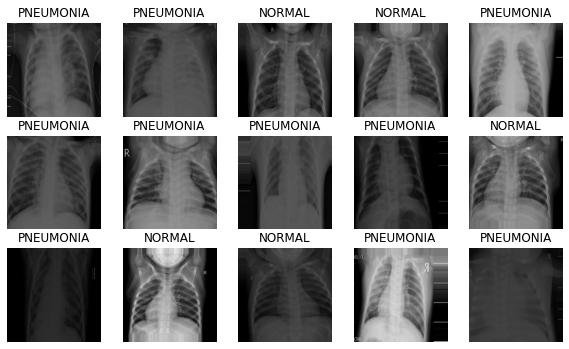

In [5]:
image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch, label_batch)

In [6]:
nb_train_samples = 5034 # number of training samples
nb_validation_samples = 16 # number of validation samples
nb_test_samples = 624 # number of training samples
epochs = 15  # number of epochs we gonna run
batch_size  = 16 # batch size ( at every iteration it will take 16 batches for training)

In [7]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

base = DenseNet169(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()

for layer in base.layers:
    layer.trainable =  False # freezing densenet layers 

densenet_model = Sequential()
densenet_model.add(base)
densenet_model.add(GlobalAveragePooling2D())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(1, activation='sigmoid'))

densenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1664)              6656      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1

In [8]:
# defined optimizer
optm = Adam(learning_rate=0.0001)
densenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

# defining callbacks 

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='test_accuracy',
                              min_delta=.01,
                              patience=7,
                              verbose=1,
                              mode='max',
                              baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="test_accuracy",
                            factor=0.01,
                            patience=3,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('./densenet169_6.h6',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

In [9]:
dense_history = densenet_model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=15,
    validation_data=validation_generator,  # Use a separate validation generator here
    callbacks=[EarlyStopping, model_save, rlr]
)


Epoch 1/15
314/314 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.7682
Epoch 1: val_loss improved from inf to 0.19891, saving model to .\densenet169_6.h6
314/314 [==============================] - 774s 2s/step - loss: 0.4921 - accuracy: 0.7682 - val_loss: 0.1989 - val_accuracy: 0.9327 - lr: 1.0000e-04
Epoch 2/15
314/314 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8687
Epoch 2: val_loss improved from 0.19891 to 0.14209, saving model to .\densenet169_6.h6
314/314 [==============================] - 707s 2s/step - loss: 0.3133 - accuracy: 0.8687 - val_loss: 0.1421 - val_accuracy: 0.9471 - lr: 1.0000e-04
Epoch 3/15
314/314 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.8858
Epoch 3: val_loss improved from 0.14209 to 0.11901, saving model to .\densenet169_6.h6
314/314 [==============================] - 995s 3s/step - loss: 0.2769 - accuracy: 0.8858 - val_loss: 0.1190 - val_accuracy: 0.9567 - lr: 1.0000e-04
Epoch 4/

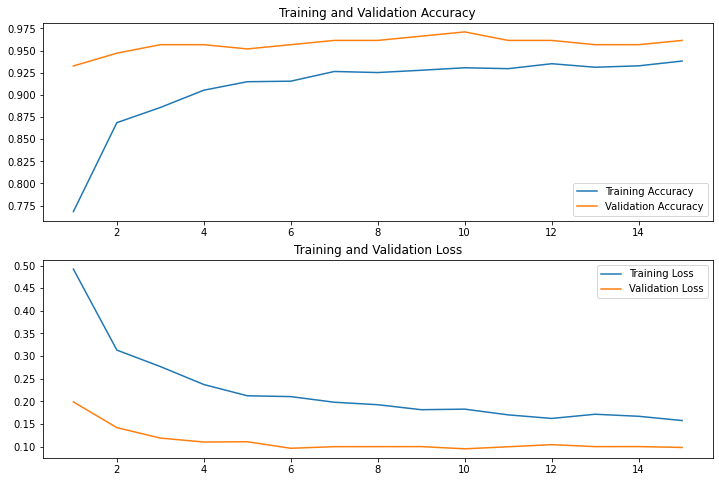

In [29]:
import matplotlib.pyplot as plt

def plot(history):

    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range = range(1, len(training_accuracy) + 1)

    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Call the plot() function with the dense_history variable
plot(dense_history)


39/39 [==============================] - 131s 3s/step - loss: 0.2541 - accuracy: 0.9199


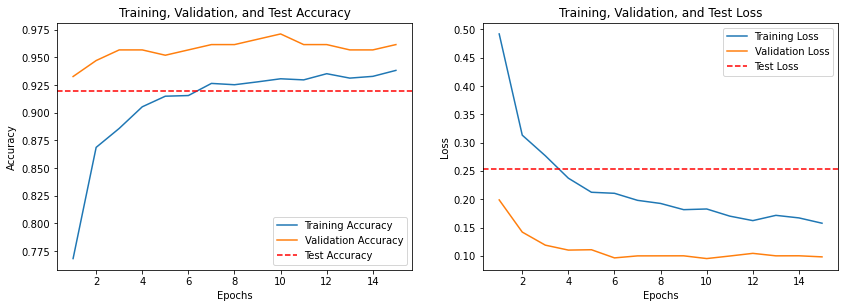

In [32]:
import matplotlib.pyplot as plt

def plot(history, test_loss, test_accuracy):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range = range(1, len(training_accuracy) + 1)  # Adjusted to start from epoch 1

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Plot test accuracy as a horizontal line
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training, Validation, and Test Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Plot test loss as a horizontal line
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.legend(loc='upper right')

    plt.show()

# Assuming you have already trained your model and obtained dense_history
# Load the model and evaluate it on the test dataset to obtain test loss and accuracy
densenet_model = keras.models.load_model('./densenet169_6.h6')  # Adjust the path accordingly
test_loss, test_accuracy = densenet_model.evaluate(test_generator)

# Call the plot() function with the obtained values
plot(dense_history, test_loss, test_accuracy)


Found 5034 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
7/7 [==============================] - 48s 6s/step - loss: 0.1124 - accuracy: 0.9519
Train Loss: 0.1756237894296646
Train Accuracy: 0.9314660429954529
Test Loss: 0.22431370615959167
Test Accuracy: 0.9230769276618958
Validation Loss: 0.11235429346561432
Validation Accuracy: 0.9519230723381042


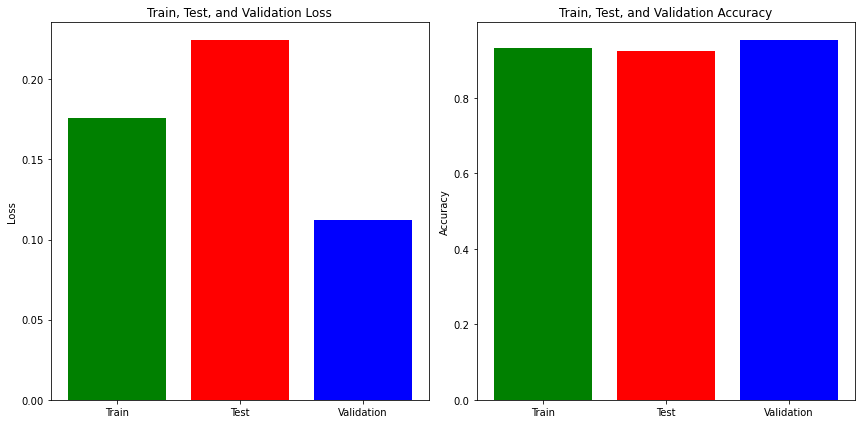

In [42]:
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator

# Load the saved model
densenet_model = load_model('./densenet169_5.h6')

# Define the image size
img_size = (224, 224)

# Define your data generators
train_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)
val_data_generator = ImageDataGenerator(rescale=1./255)

# Load your train, test, and validation datasets
train_data = train_data_generator.flow_from_directory(
    r"C:\Users\AVINASH G\code\elseftron\P3-Xray images\train",
    target_size=img_size,
    batch_size=32,
    class_mode='binary',  # Modify this based on your task
    shuffle=True
)

test_data = test_data_generator.flow_from_directory(
    r"C:\Users\AVINASH G\code\elseftron\P3-Xray images\test",
    target_size=img_size,
    batch_size=32,
    class_mode='binary',  # Modify this based on your task
    shuffle=False  # Ensure that the order of predictions matches the order of actual labels
)

val_data = val_data_generator.flow_from_directory(
    r"C:\Users\AVINASH G\code\elseftron\P3-Xray images\val",
    target_size=img_size,
    batch_size=32,
    class_mode='binary',  # Modify this based on your task
    shuffle=False  # Ensure that the order of predictions matches the order of actual labels
)

# Evaluate the model on train, test, and validation data
train_loss, train_accuracy = densenet_model.evaluate(train_data)
test_loss, test_accuracy = densenet_model.evaluate(test_data)
val_loss, val_accuracy = densenet_model.evaluate(val_data)

print('Train Loss:', train_loss)
print('Train Accuracy:', train_accuracy)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)

# Plotting
plt.figure(figsize=(18, 6))

# Plot train, test, and validation loss
plt.subplot(1, 3, 1)
plt.bar(['Train', 'Test', 'Validation'], [train_loss, test_loss, val_loss], color=['green', 'red', 'blue'])
plt.title('Train, Test, and Validation Loss')
plt.ylabel('Loss')

# Plot train, test, and validation accuracy
plt.subplot(1, 3, 2)
plt.bar(['Train', 'Test', 'Validation'], [train_accuracy, test_accuracy, val_accuracy], color=['green', 'red', 'blue'])
plt.title('Train, Test, and Validation Accuracy')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [22]:
test_data = []
test_normal_path = test_data_dir + r'\NORMAL'
test_pneumonia_path = test_data_dir + r'\PNEUMONIA'
for filename in os.listdir(test_normal_path):
    test_data.append((os.path.join(test_normal_path,filename),0))
for filename in os.listdir(test_pneumonia_path):
    test_data.append((os.path.join(test_pneumonia_path,filename),1))    
    
    
    
    
test_df = pd.DataFrame(test_data, columns = ['img_path','label'], index = None)


In [33]:
densenet_model = keras.models.load_model('./densenet169_6.h6')

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
def process_image(image):
    image = image/255
    image = cv2.resize(image, (224,224))
    return image


def testing(model, test_df):
    """ the passed data must be the img_path columns and label column"""
    base_pred =[]
    for image in test_df.img_path:
        base_pred.append(predict(image , model)[0][0])
    
    final_base_pred  = np.where(np.array(base_pred)>0.5,1,0)
    actual_label = test_df['label']
    # print(final_base_pred)

    print(classification_report(actual_label, final_base_pred))
    matrix=confusion_matrix(actual_label, final_base_pred)
    sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

1/1 [==============================] - 1s 606ms/step
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       234
           1       0.92      0.95      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



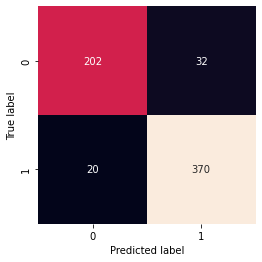

In [35]:
testing(densenet_model, test_df)